In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from client.image_data_generator import ImageDataGenerator

In [ ]:
DATASET_PATH = "./images-data1/"
TEST_DATASET_PATH = "./images-data1-test/"
MASK_PATH = "./images-data1-mask/mask-2.mat"

EMBEDDING_FEATURE_DIM = 1024

EPOCHS = 10
BATCH_SIZE = 4

In [ ]:
train_data = ImageDataGenerator(dataset_path=DATASET_PATH, mask_path=MASK_PATH)
test_data = ImageDataGenerator(dataset_path=TEST_DATASET_PATH, mask_path=MASK_PATH)

In [ ]:
train_ds = (
    tf.data.Dataset.from_generator(
        train_data,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        ),
    )
    .shuffle(100)
    .batch(BATCH_SIZE)
)


test_ds = tf.data.Dataset.from_generator(
    test_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=(
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
    ),
).batch(1)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(EMBEDDING_FEATURE_DIM)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(2, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(EMBEDDING_FEATURE_DIM),
    ]
)

model.compile(loss="mse", optimizer="adam", metrics="mse")

In [ ]:
model.fit(train_ds, epochs=EPOCHS)

1/1 [==============================] - 0s 14ms/step


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


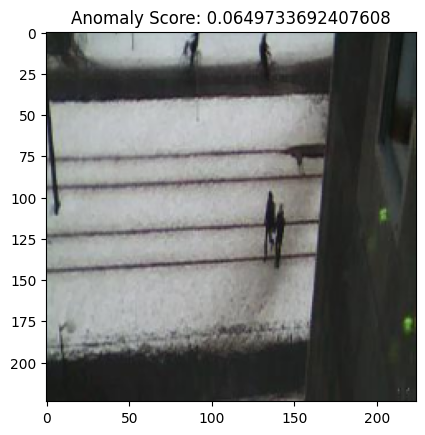

1/1 [==============================] - 0s 14ms/step


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


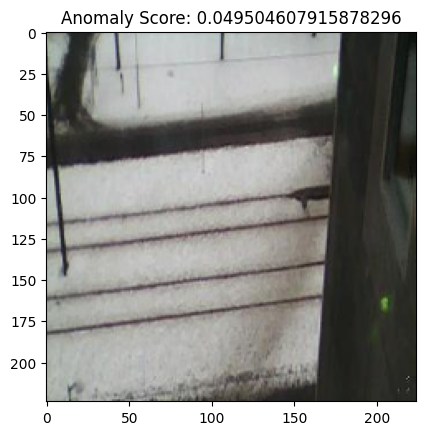

1/1 [==============================] - 0s 22ms/step


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


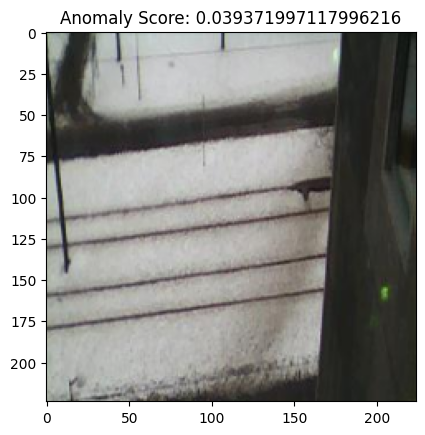

1/1 [==============================] - 0s 14ms/step


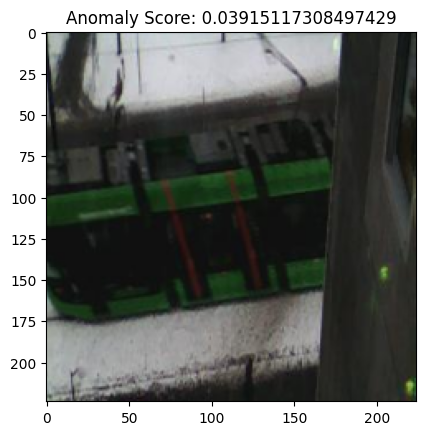

In [16]:
for ix, (x, y) in enumerate(test_ds):
    pred = model.predict(x)

    score = tf.reduce_mean(tf.math.square(x - pred))

    plt.figure()
    plt.imshow(test_data.get_image(ix, apply_mask=False))
    plt.title(f"Anomaly Score: {score}")
    plt.show()